### import required libraries

In [1]:

import numpy as numpy
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from geopy.geocoders import Nominatim
import pycountry_convert as pc

In [2]:
df = pd.read_csv("earthquake_data.csv")

df.head(5)

,title,magnitude,date_time,cdi,mmi,alert,tsunami,sig,net,nst,dmin,gap,magType,depth,latitude,longitude,location,continent,country
0,"M 7.0 - 18 km SW of Malango, Solomon Islands",7.0,22-11-2022 02:03,8,7,green,1,768,us,117,0.509,17.0,mww,14.000,-9.7963,159.596,"Malango, Solomon Islands",Oceania,Solomon Islands
1,"M 6.9 - 204 km SW of Bengkulu, Indonesia",6.9,18-11-2022 13:37,4,4,green,0,735,us,99,2.229,34.0,mww,25.000,-4.9559,100.738,"Bengkulu, Indonesia",NaN,NaN
2,M 7.0 -,7.0,12-11-2022 07:09,3,3,green,1,755,us,147,3.125,18.0,mww,579.000,-20.0508,-178.346,NaN,Oceania,Fiji
3,"M 7.3 - 205 km ESE of Neiafu, Tonga",7.3,11-11-2022 10:48,5,5,green,1,833,us,149,1.865,21.0,mww,37.000,-19.2918,-172.129,"Neiafu, Tonga",NaN,NaN
4,M 6.6 -,6.6,09-11-2022 10:14,0,2,green,1,670,us,131,4.998,27.0,mww,624.464,-25.5948,178.278,NaN,NaN,NaN


missing data heatmap

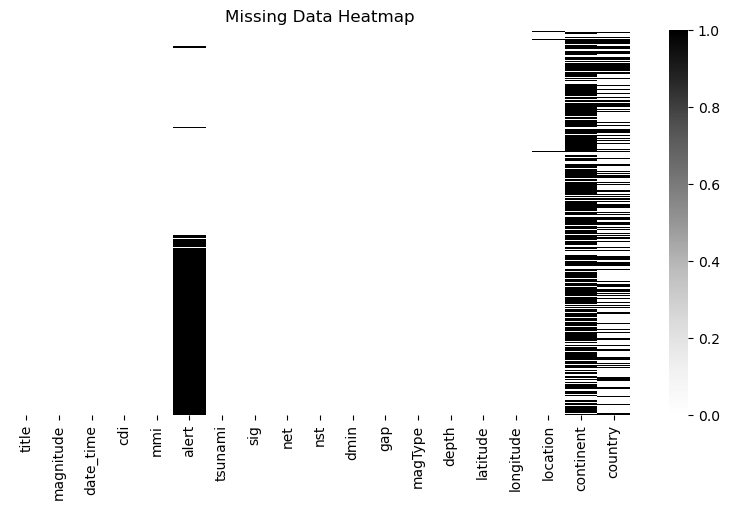

In [3]:
plt.figure(figsize=(10,5))
sns.heatmap(df.isna(), cmap='Greys', yticklabels=False)
plt.title('Missing Data Heatmap')
plt.show()

Try finding the country and continent based on the location with geopy library

In [78]:
geolocator = Nominatim(user_agent='location_geocoder')

# Iterate through the data
for index, row in df.iterrows():
    location = row['location']
    continent = row['continent']
    country = row['country']

    if pd.isnull(continent) and pd.isnull(country):
        try:
            # Geocode the location to get the continent and country
            location_info = geolocator.geocode(location, exactly_one=True, addressdetails=True)
            if location_info is not None:
                address = location_info.raw['address']
                continent = address.get('continent', None)
                country = address.get('country', None)

                # Update the DataFrame
                df.at[index, 'continent'] = continent
                df.at[index, 'country'] = country

                print(f"Updated continent and country for location '{location}'")
            else:
                print(f"No geocode found for location '{location}'")

        except Exception as e:
            print(f"Error geocoding location '{location}': {str(e)}")

    # If continent is still null, try finding it using the country from previous iterations or saved data
    if pd.isnull(continent) and not pd.isnull(country):
        try:
            # Search for the country in the DataFrame up to the current index
            previous_rows = df.loc[:index]
            matching_rows = previous_rows[previous_rows['country'] == country]

            if len(matching_rows) > 0:
                # Get the continent from the first matching row
                continent = matching_rows.iloc[0]['continent']

                # Update the DataFrame
                df.at[index, 'continent'] = continent

                print(f"Updated continent for location '{location}' using country '{country}' from previous data")
            else:
                # If not found, try geocoding the country again
                country_info = geolocator.geocode(country, exactly_one=True, addressdetails=True)
                if country_info is not None:
                    address = country_info.raw['address']
                    continent = address.get('continent', None)

                    # Update the DataFrame
                    df.at[index, 'continent'] = continent

                    print(f"Updated continent for location '{location}' using country '{country}'")
                else:
                    print(f"No geocode found for country '{country}'")

        except Exception as e:
            print(f"Error geocoding country '{country}': {str(e)}")

# Save the updated DataFrame to a new CSV file
output_file = 'earthquake2.csv'
df.to_csv(output_file, index=False)
print(f"Saved updated DataFrame to '{output_file}'")


Updated continent and country for location 'Bengkulu, Indonesia'
Updated continent for location 'Bengkulu, Indonesia' using country 'Indonesia' from previous data
Updated continent and country for location 'Neiafu, Tonga'
Updated continent for location 'Neiafu, Tonga' using country 'Tonga' from previous data
Updated continent and country for location 'nan'
Updated continent for location 'nan' using country 'Italia' from previous data
Updated continent and country for location 'the Fiji Islands'
Updated continent for location 'the Fiji Islands' using country 'Viti' from previous data
Updated continent and country for location 'the Fiji Islands'
Updated continent for location 'the Fiji Islands' using country 'Viti' from previous data
Updated continent for location 'Boca Chica, Panama' using country 'Panama' from previous data
Updated continent and country for location 'Isangel, Vanuatu'
Updated continent for location 'Isangel, Vanuatu' using country 'Vanuatu' from previous data
No geocod

making use of the already aquired countries to fill in the continent column

In [79]:

def update_continents(df):
    for index, row in df.iterrows():
        country = row['country']
        if not pd.isnull(country):
            try:
                # Convert country to continent
                country_alpha2 = pc.country_name_to_country_alpha2(country)
                continent_code = pc.country_alpha2_to_continent_code(country_alpha2)
                continent = pc.convert_continent_code_to_continent_name(continent_code)

                # Update the DataFrame
                df.at[index, 'continent'] = continent

                print(f"Updated continent for country '{country}'")

            except Exception as e:
                print(f"Error updating continent for country '{country}': {str(e)}")

    return df

# Example usage
input_file = 'earthquake2.csv'
output_file = 'earthquake3.csv'

df = pd.read_csv(input_file)
df_updated = update_continents(df)
df_updated.to_csv(output_file, index=False)
print(f"Saved updated DataFrame to '{output_file}'")


Updated continent for country 'Solomon Islands'
Updated continent for country 'Indonesia'
Updated continent for country 'Fiji'
Updated continent for country 'Tonga'
Error updating continent for country 'Italia': "Invalid Country Name: 'Italia'"
Error updating continent for country 'Viti': "Invalid Country Name: 'Viti'"
Error updating continent for country 'Viti': "Invalid Country Name: 'Viti'"
Updated continent for country 'Panama'
Updated continent for country 'Mexico'
Updated continent for country 'Mexico'
Updated continent for country 'Taiwan'
Updated continent for country 'Taiwan'
Updated continent for country 'Vanuatu'
Updated continent for country 'Papua New Guinea'
Updated continent for country 'People's Republic of China'
Updated continent for country 'Philippines'
Updated continent for country 'Brazil'
Updated continent for country 'Peru'
Error updating continent for country 'Italia': "Invalid Country Name: 'Italia'"
Updated continent for country 'Argentina'
Updated continent 

In [5]:
df2 = pd.read_csv("earthquake3.csv")

In [6]:
df2.head()

,title,magnitude,date_time,cdi,mmi,alert,tsunami,sig,net,nst,dmin,gap,magType,depth,latitude,longitude,location,continent,country
0,"M 7.0 - 18 km SW of Malango, Solomon Islands",7.0,22-11-2022 02:03,8,7,green,1,768,us,117,0.509,17.0,mww,14.000,-9.7963,159.596,"Malango, Solomon Islands",Oceania,Solomon Islands
1,"M 6.9 - 204 km SW of Bengkulu, Indonesia",6.9,18-11-2022 13:37,4,4,green,0,735,us,99,2.229,34.0,mww,25.000,-4.9559,100.738,"Bengkulu, Indonesia",Asia,Indonesia
2,M 7.0 -,7.0,12-11-2022 07:09,3,3,green,1,755,us,147,3.125,18.0,mww,579.000,-20.0508,-178.346,NaN,Oceania,Fiji
3,"M 7.3 - 205 km ESE of Neiafu, Tonga",7.3,11-11-2022 10:48,5,5,green,1,833,us,149,1.865,21.0,mww,37.000,-19.2918,-172.129,"Neiafu, Tonga",Oceania,Tonga
4,M 6.6 -,6.6,09-11-2022 10:14,0,2,green,1,670,us,131,4.998,27.0,mww,624.464,-25.5948,178.278,NaN,NaN,Italia


In [7]:
print(f"the number of continents: {df2['continent'].nunique()} \n")

print(f"continent list: {df2['continent'].unique()} \n")

continent_frequency=df2["continent"].value_counts()
print(continent_frequency)

the number of continents: 6 

continent list: ['Oceania' 'Asia' nan 'North America' 'South America' 'Europe' 'Africa'] 

Asia             227
Oceania          169
North America    100
South America     91
Europe            44
Africa             4
Name: continent, dtype: int64


The number of country: 66 

Country list: ['Solomon Islands' 'Indonesia' 'Fiji' 'Tonga' 'Italia' 'Viti' 'Panama'
 'Mexico' 'Taiwan' 'Vanuatu' 'Papua New Guinea'
 "People's Republic of China" nan 'Philippines' 'Brazil' 'Peru'
 'Argentina' 'Nicaragua' 'France' 'Japan' 'New Zealand/Aotearoa'
 'United States' 'United States of America' 'Brasil' 'Antarctica' 'Haiti'
 'Mongolia' 'Chile' 'Greece' 'Ελλάς' 'Россия' 'Russia' 'Jamaica' 'Turkey'
 'United Kingdom of Great Britain and Northern Ireland (the)' 'Australia'
 'El Salvador' 'South Georgia and the South Sandwich Islands' 'Ecuador'
 'Canada' 'Venezuela' 'Bolivia' 'Honduras' 'Costa Rica' 'Iran' 'México'
 'Guatemala' 'Botswana' 'New Zealand' 'Italy' 'Myanmar' 'Afghanistan'
 'India' 'Tajikistan' 'Barbados' 'Nepal' 'Papua Niugini' 'Panamá'
 'Pakistan' 'Colombia' 'Sāmoa' 'Kyrgyzstan' 'Martinique' 'Mozambique'
 'Tanzania' 'Cayman Islands' 'Algeria'] 

Indonesia           119
Papua New Guinea     56
Japan                51
Chile                49


In [109]:
replace_dict = {
    'Россия': 'Russia',
    "People's Republic of China": 'China',
    '日本': 'Japan',
    "New Zealand/Aotearoa" : "New Zealand",
    'Ελλάς' : 'Greece',
    "United Kingdom of Great Britain and Northern Ireland (the)" : "United Kingdom",
    "South Georgia and the South Sandwich Islands" : 'Georgia',
    'México' : 'Mexico'
    
    
    
    
}

for index, value in enumerate(df2['country']):
    if value in replace_dict:
        df2.at[index, 'country'] = replace_dict[value]


In [110]:
df2['country'].unique()

array(['Solomon Islands', 'Indonesia', 'Fiji', 'Tonga', 'Italia', 'Viti',
       'Panama', 'Mexico', 'Taiwan', 'Vanuatu', 'Papua New Guinea',
       'China', nan, 'Philippines', 'Brazil', 'Peru', 'Argentina',
       'Nicaragua', 'France', 'Japan', 'New Zealand', 'United States',
       'United States of America', 'Brasil', 'Antarctica', 'Haiti',
       'Mongolia', 'Chile', 'Greece', 'Russia', 'Jamaica', 'Turkey',
       'United Kingdom', 'Australia', 'El Salvador', 'Georgia', 'Ecuador',
       'Canada', 'Venezuela', 'Bolivia', 'Honduras', 'Costa Rica', 'Iran',
       'Guatemala', 'Botswana', 'Italy', 'Myanmar', 'Afghanistan',
       'India', 'Tajikistan', 'Barbados', 'Nepal', 'Papua Niugini',
       'Panamá', 'Pakistan', 'Colombia', 'Sāmoa', 'Kyrgyzstan',
       'Martinique', 'Mozambique', 'Tanzania', 'Cayman Islands',
       'Algeria'], dtype=object)

In [111]:
#use the updated country to get the continents

def update_continents(df):
    for index, row in df.iterrows():
        country = row['country']
        if not pd.isnull(country):
            try:
                # Convert country to continent
                country_alpha2 = pc.country_name_to_country_alpha2(country)
                continent_code = pc.country_alpha2_to_continent_code(country_alpha2)
                continent = pc.convert_continent_code_to_continent_name(continent_code)

                # Update the DataFrame
                df.at[index, 'continent'] = continent

                print(f"Updated continent for country '{country}'")

            except Exception as e:
                print(f"Error updating continent for country '{country}': {str(e)}")

    return df

# Example usage
input_file = 'earthquake2.csv'
output_file = 'earthquake3.csv'

df = pd.read_csv(input_file)
df_updated = update_continents(df)
df_updated.to_csv(output_file, index=False)
print(f"Saved updated DataFrame to '{output_file}'")


Updated continent for country 'Solomon Islands'
Updated continent for country 'Indonesia'
Updated continent for country 'Fiji'
Updated continent for country 'Tonga'
Error updating continent for country 'Italia': "Invalid Country Name: 'Italia'"
Error updating continent for country 'Viti': "Invalid Country Name: 'Viti'"
Error updating continent for country 'Viti': "Invalid Country Name: 'Viti'"
Updated continent for country 'Panama'
Updated continent for country 'Mexico'
Updated continent for country 'Mexico'
Updated continent for country 'Taiwan'
Updated continent for country 'Taiwan'
Updated continent for country 'Vanuatu'
Updated continent for country 'Papua New Guinea'
Updated continent for country 'People's Republic of China'
Updated continent for country 'Philippines'
Updated continent for country 'Brazil'
Updated continent for country 'Peru'
Error updating continent for country 'Italia': "Invalid Country Name: 'Italia'"
Updated continent for country 'Argentina'
Updated continent 

Heatmap showing missing data after adding countries and continent

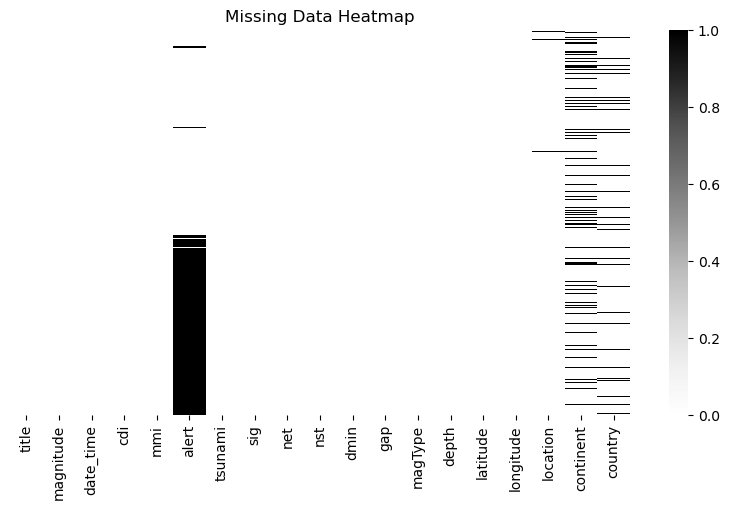

In [24]:
plt.figure(figsize=(10,5))
sns.heatmap(df.isna(), cmap='Greys', yticklabels=False)
plt.title('Missing Data Heatmap')
plt.show()

In [27]:
df['country']= df['location'].str.split(',').str[-1].str.strip()
df.head()

,title,magnitude,date_time,cdi,mmi,alert,tsunami,sig,net,nst,dmin,gap,magType,depth,latitude,longitude,location,continent,country
0,"M 7.0 - 18 km SW of Malango, Solomon Islands",7.0,22-11-2022 02:03,8,7,green,1,768,us,117,0.509,17.0,mww,14.000,-9.7963,159.596,"Malango, Solomon Islands",Oceania,Solomon Islands
1,"M 6.9 - 204 km SW of Bengkulu, Indonesia",6.9,18-11-2022 13:37,4,4,green,0,735,us,99,2.229,34.0,mww,25.000,-4.9559,100.738,"Bengkulu, Indonesia",Asia,Indonesia
2,M 7.0 -,7.0,12-11-2022 07:09,3,3,green,1,755,us,147,3.125,18.0,mww,579.000,-20.0508,-178.346,NaN,Oceania,NaN
3,"M 7.3 - 205 km ESE of Neiafu, Tonga",7.3,11-11-2022 10:48,5,5,green,1,833,us,149,1.865,21.0,mww,37.000,-19.2918,-172.129,"Neiafu, Tonga",Oceania,Tonga
4,M 6.6 -,6.6,09-11-2022 10:14,0,2,green,1,670,us,131,4.998,27.0,mww,624.464,-25.5948,178.278,NaN,NaN,NaN


In [28]:
df.isnull().sum()

title          0
magnitude      0
date_time      0
cdi            0
mmi            0
alert        367
tsunami        0
sig            0
net            0
nst            0
dmin           0
gap            0
magType        0
depth          0
latitude       0
longitude      0
location       5
continent    147
country        5
dtype: int64

In [29]:
df.to_csv('earthquake1.csv', index= False)

In [30]:
df2= pd.read_csv('earthquake1.csv')
df2.isnull().sum()

title          0
magnitude      0
date_time      0
cdi            0
mmi            0
alert        367
tsunami        0
sig            0
net            0
nst            0
dmin           0
gap            0
magType        0
depth          0
latitude       0
longitude      0
location       5
continent    147
country        5
dtype: int64

In [31]:
#use the updated country to get the continents

def update_continents(df2):
    for index, row in df.iterrows():
        country = row['country']
        if not pd.isnull(country):
            try:
                # Convert country to continent
                country_alpha2 = pc.country_name_to_country_alpha2(country)
                continent_code = pc.country_alpha2_to_continent_code(country_alpha2)
                continent = pc.convert_continent_code_to_continent_name(continent_code)

                # Update the DataFrame
                df.at[index, 'continent'] = continent

                print(f"Updated continent for country '{country}'")

            except Exception as e:
                print(f"Error updating continent for country '{country}': {str(e)}")

    return df

# Example usage
input_file = 'earthquake1.csv'
output_file = 'earthquake5.csv'

df2 = pd.read_csv(input_file)
df_updated = update_continents(df2)
df_updated.to_csv(output_file, index=False)
print(f"Saved updated DataFrame to '{output_file}'")


Updated continent for country 'Solomon Islands'
Updated continent for country 'Indonesia'
Updated continent for country 'Tonga'
Error updating continent for country 'the Fiji Islands': "Invalid Country Name: 'the Fiji Islands'"
Error updating continent for country 'the Fiji Islands': "Invalid Country Name: 'the Fiji Islands'"
Updated continent for country 'Panama'
Updated continent for country 'Mexico'
Updated continent for country 'Mexico'
Updated continent for country 'Taiwan'
Updated continent for country 'Taiwan'
Updated continent for country 'Vanuatu'
Updated continent for country 'Papua New Guinea'
Updated continent for country 'China'
Error updating continent for country 'the Kermadec Islands': "Invalid Country Name: 'the Kermadec Islands'"
Updated continent for country 'Philippines'
Updated continent for country 'Brazil'
Updated continent for country 'Peru'
Updated continent for country 'Argentina'
Updated continent for country 'Nicaragua'
Error updating continent for country '

Updated continent and country for location 'nan'
Updated continent for location 'nan' using country 'Italia' from previous data
Updated continent for location 'the Fiji Islands' using country 'the Fiji Islands' from previous data
Updated continent for location 'the Fiji Islands' using country 'the Fiji Islands' from previous data
Updated continent for location 'the Kermadec Islands' using country 'the Kermadec Islands' from previous data
Updated continent and country for location 'nan'
Updated continent for location 'nan' using country 'Italia' from previous data
Updated continent for location 'the Fiji Islands' using country 'the Fiji Islands' from previous data
Updated continent for location 'Kermadec Islands region' using country 'Kermadec Islands region' from previous data
Updated continent for location 'Vanuatu region' using country 'Vanuatu region' from previous data
Updated continent for location 'Vanuatu region' using country 'Vanuatu region' from previous data
Updated continen

In [36]:
df=pd.read_csv("earthquake5.csv")
df.isnull().sum()

title          0
magnitude      0
date_time      0
cdi            0
mmi            0
alert        367
tsunami        0
sig            0
net            0
nst            0
dmin           0
gap            0
magType        0
depth          0
latitude       0
longitude      0
location       5
continent     54
country        5
dtype: int64

In [34]:
print(f"The number of country: {df2['country'].nunique()} \n")

print(f"Country list: {df2['country'].unique()} \n")

country_frequency=df2["country"].value_counts()
print(country_frequency)

The number of country: 100 

Country list: ['Solomon Islands' 'Indonesia' nan 'Tonga' 'the Fiji Islands' 'Panama'
 'Mexico' 'Taiwan' 'Vanuatu' 'Papua New Guinea' 'China'
 'the Kermadec Islands' 'Philippines' 'Brazil' 'Peru' 'Argentina'
 'Nicaragua' 'the Loyalty Islands' 'New Caledonia' 'Japan' 'New Zealand'
 'Kermadec Islands region' 'Alaska' 'Cyprus' 'Timor Leste' 'Flores Sea'
 'Vanuatu region' 'South Sandwich Islands region' 'Haiti'
 'Wallis and Futuna' 'Mauritius - Reunion region' 'Russia'
 'South Shetland Islands' 'Mongolia' 'Chile' 'Greece'
 'central Mid-Atlantic Ridge' 'NV Earthquake' 'Banda Sea' 'Idaho'
 'Jamaica' 'Turkey' 'Fiji' 'South Sandwich Islands' 'Australia' 'CA'
 'El Salvador' 'Ecuador' 'Prince Edward Islands region' 'Molucca Sea'
 'Svalbard and Jan Mayen' 'Canada' 'Venezuela' 'Hawaii' 'Bolivia'
 'Honduras' 'Bouvet Island region' 'Costa Rica' 'Iraq' 'Russia region'
 'New Zealand region' 'Guatemala' 'Botswana' 'California' 'Tajikistan'
 'Italy' 'Fiji region' 'Myanmar' 'N

IndexError: list index out of range

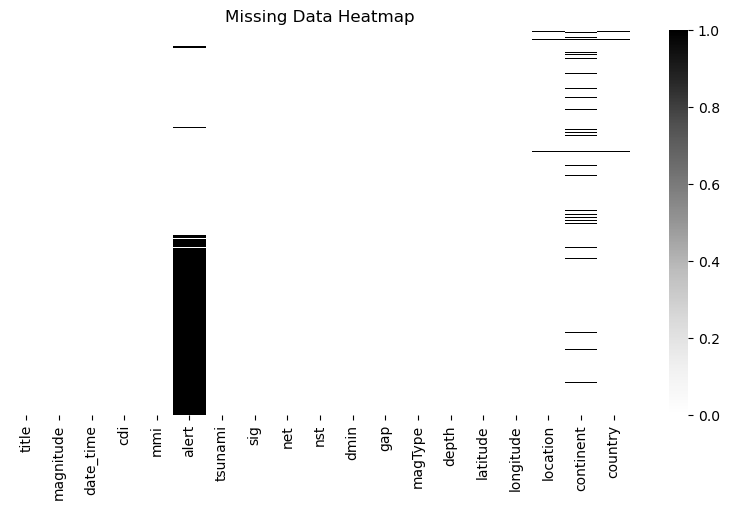

In [39]:
plt.figure(figsize=(10,5))
sns.heatmap(df.isna(), cmap='Greys', yticklabels=False)
plt.title('Missing Data Heatmap')
plt.show()

In [11]:
missing_country= df[df['country'].isnull()] #show missing countries and where its located on the data
missing_country

,title,magnitude,date_time,cdi,mmi,alert,tsunami,sig,net,nst,dmin,gap,magType,depth,latitude,longitude,location,continent,country
2,M 7.0 -,7.0,12-11-2022 07:09,3,3,green,1,755,us,147,3.125,18.0,mww,579.000,-20.0508,-178.346,NaN,Oceania,NaN
4,M 6.6 -,6.6,09-11-2022 10:14,0,2,green,1,670,us,131,4.998,27.0,mww,624.464,-25.5948,178.278,NaN,NaN,NaN
19,M 6.9 -,6.9,19-05-2022 10:13,2,5,green,1,733,us,127,0.371,45.0,mww,10.000,-54.1325,159.027,NaN,NaN,NaN
68,M 6.9 -,6.9,01-05-2021 01:27,7,6,green,1,919,us,0,2.619,35.0,mww,43.000,38.2296,141.665,NaN,Asia,NaN
246,M 6.9 -,6.9,28-05-2016 05:38,3,3,green,1,733,us,0,5.485,19.0,mww,405.690,-21.9724,-178.204,NaN,NaN,NaN


In [132]:
# Features with null values
print(f"Features with null values count before cleaning:'\n'{df.isnull().sum()[df.isnull().sum() > 0]},'\n'")

print(f"Features with null values count before cleaning:'\n'{df2.isnull().sum()[df.isnull().sum() > 0]}")

Features with null values count before cleaning:'
'alert        367
location       5
continent    576
country      298
dtype: int64,'
'
Features with null values count before cleaning:'
'alert        367
location       5
continent    147
country       72
dtype: int64


In [15]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 782 entries, 0 to 781
Data columns (total 19 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   title      782 non-null    object 
 1   magnitude  782 non-null    float64
 2   date_time  782 non-null    object 
 3   cdi        782 non-null    int64  
 4   mmi        782 non-null    int64  
 5   alert      415 non-null    object 
 6   tsunami    782 non-null    int64  
 7   sig        782 non-null    int64  
 8   net        782 non-null    object 
 9   nst        782 non-null    int64  
 10  dmin       782 non-null    float64
 11  gap        782 non-null    float64
 12  magType    782 non-null    object 
 13  depth      782 non-null    float64
 14  latitude   782 non-null    float64
 15  longitude  782 non-null    float64
 16  location   777 non-null    object 
 17  continent  206 non-null    object 
 18  country    777 non-null    object 
dtypes: float64(6), int64(5), object(8)
memory usage: 1

In [14]:
print(df.describe())

        magnitude         cdi         mmi     tsunami          sig  \
count  782.000000  782.000000  782.000000  782.000000   782.000000   
mean     6.941125    4.333760    5.964194    0.388747   870.108696   
std      0.445514    3.169939    1.462724    0.487778   322.465367   
min      6.500000    0.000000    1.000000    0.000000   650.000000   
25%      6.600000    0.000000    5.000000    0.000000   691.000000   
50%      6.800000    5.000000    6.000000    0.000000   754.000000   
75%      7.100000    7.000000    7.000000    1.000000   909.750000   
max      9.100000    9.000000    9.000000    1.000000  2910.000000   

              nst        dmin         gap       depth    latitude   longitude  
count  782.000000  782.000000  782.000000  782.000000  782.000000  782.000000  
mean   230.250639    1.325757   25.038990   75.883199    3.538100   52.609199  
std    250.188177    2.218805   24.225067  137.277078   27.303429  117.898886  
min      0.000000    0.000000    0.000000    2.70

### The distribution of frequency and magnitude to understand the skewness of the data

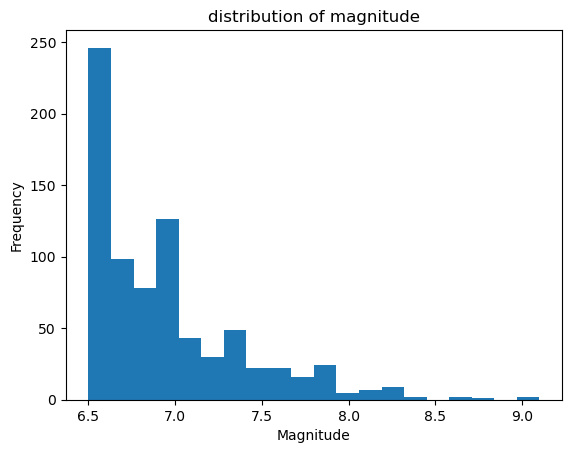

In [16]:
plt.hist(df['magnitude'], bins=20)
plt.xlabel('Magnitude')
plt.ylabel('Frequency')
plt.title('distribution of magnitude')
plt.show()

### Analyze categorical variables

In [4]:
df= pd.read_csv('earthquake_data.csv')
df.head()

,title,magnitude,date_time,cdi,mmi,alert,tsunami,sig,net,nst,dmin,gap,magType,depth,latitude,longitude,location,continent,country
0,"M 7.0 - 18 km SW of Malango, Solomon Islands",7.0,22-11-2022 02:03,8,7,green,1,768,us,117,0.509,17.0,mww,14.000,-9.7963,159.596,"Malango, Solomon Islands",Oceania,Solomon Islands
1,"M 6.9 - 204 km SW of Bengkulu, Indonesia",6.9,18-11-2022 13:37,4,4,green,0,735,us,99,2.229,34.0,mww,25.000,-4.9559,100.738,"Bengkulu, Indonesia",NaN,NaN
2,M 7.0 -,7.0,12-11-2022 07:09,3,3,green,1,755,us,147,3.125,18.0,mww,579.000,-20.0508,-178.346,NaN,Oceania,Fiji
3,"M 7.3 - 205 km ESE of Neiafu, Tonga",7.3,11-11-2022 10:48,5,5,green,1,833,us,149,1.865,21.0,mww,37.000,-19.2918,-172.129,"Neiafu, Tonga",NaN,NaN
4,M 6.6 -,6.6,09-11-2022 10:14,0,2,green,1,670,us,131,4.998,27.0,mww,624.464,-25.5948,178.278,NaN,NaN,NaN
